In [ ]:
!pip install -q --no-deps tensorflow-addons~=0.7

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Reshape, Conv2DTranspose, Dropout
from tensorflow.keras.layers import Reshape, MaxPooling2D, Softmax, Lambda
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, LeakyReLU, Conv3D
from tensorflow.keras.optimizers import Adam, SGD
from skimage.color import rgb2gray


c:\Users\nicte\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Load Data

In [2]:
# mount google drive to virtual machine using an authorization code

from google.colab import drive

drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
folder = 'drive/My Drive/Colab Notebooks/DLOI/week10'
for root, dirs, files in os.walk(folder):
  for filename in files:
    print(os.path.join(root, filename))

drive/My Drive/Colab Notebooks/DLOI/week10/DLOI_week10_TripletSemiHardLoss_Mnist.ipynb
drive/My Drive/Colab Notebooks/DLOI/week10/20faces-cropeed-train-128x128.npy
drive/My Drive/Colab Notebooks/DLOI/week10/20faces-cropeed-trainlbl-128x128.npy
drive/My Drive/Colab Notebooks/DLOI/week10/20faces-cropeed-test-128x128.npy
drive/My Drive/Colab Notebooks/DLOI/week10/20faces-cropeed-testlbl-128x128.npy
drive/My Drive/Colab Notebooks/DLOI/week10/Copy of TripletSemiHardLoss_Mnist.ipynb


In [ ]:
train0 = np.load('drive/My Drive/Colab Notebooks/DLOI/week10/20faces-cropeed-train-128x128.npy')
trainlbl0 = np.load('drive/My Drive/Colab Notebooks/DLOI/week10/20faces-cropeed-trainlbl-128x128.npy')
test0 = np.load('drive/My Drive/Colab Notebooks/DLOI/week10/20faces-cropeed-test-128x128.npy')
testlbl0 = np.load('drive/My Drive/Colab Notebooks/DLOI/week10/20faces-cropeed-testlbl-128x128.npy')

(5535,)


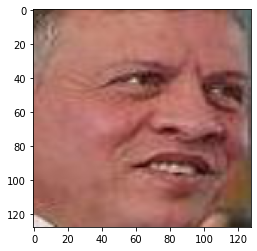

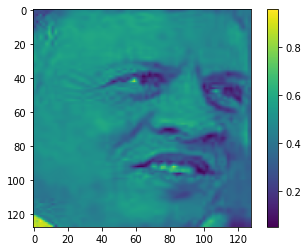

In [ ]:
print(np.shape(trainlbl0))
plt.imshow(train0[120])
plt.show()
plt.imshow(rgb2gray(train0)[120])
plt.colorbar()

In [ ]:
print(testlbl0)

[ 0  0  0 ... 19 19 19]


## 1: Discriminator

In [230]:
train=rgb2gray(train0)
test=rgb2gray(test0)

discriminate = lambda lbl: int(lbl==0)
   
trainlbl= np.array([discriminate(lbl) for lbl in trainlbl0])
testlbl= np.array([discriminate(lbl) for lbl in testlbl0])

In [231]:
train= train.reshape(train.shape[0], 128, 128, 1)  # add an extra dimension to array
test= test.reshape(test.shape[0], 128, 128, 1)  # add an extra dimension to array
output_train_class_onehot = tf.keras.utils.to_categorical(trainlbl, 2)  # create one-hot encoded class
output_test_class_onehot = tf.keras.utils.to_categorical(testlbl, 2)

In [232]:
train.shape
output_train_class_onehot[1000]

array([1., 0.], dtype=float32)

In [233]:
model = tf.keras.Sequential([
    Conv2D(filters=32, kernel_size=3, strides=(1,1), padding='same', activation='relu', input_shape=(128,128,1)),
    MaxPooling2D(pool_size=4),
    Dropout(0.3),
    Conv2D(filters=64, kernel_size=3, strides=(1,1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=4),
    Dropout(0.3),
    Conv2D(filters=128, kernel_size=3, strides=(1,1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=4),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='sigmoid'), # No activation on final dense layer
])

In [234]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_70 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 8, 8, 128)       

In [244]:
validtrain_split_ratio = 0.2  # % of the seen dataset to be put aside for validation, rest is for training
max_epochs = 100  # maxmimum number of epochs to be iterated
batch_size = 32   # batch size for the training data set
batch_shuffle = True   # shuffle the training data prior to batching before each epoch

In [248]:
# Compile the model

triplet_loss=tfa.losses.TripletSemiHardLoss()
def network_loss(label,output):  
  loss=triplet_loss(label,output)  
  return loss

model.compile(
    optimizer=Adam(0.001),
    loss='binary_crossentropy',
    metrics = ['binary_accuracy'])

In [249]:
print(np.shape(output_train_class_onehot))
print(np.shape(train))

(5535, 2)
(5535, 128, 128, 1)


In [250]:

# Train the network
history = model.fit(train,output_train_class_onehot, \
    batch_size=batch_size, \
    epochs=max_epochs, \
    validation_split=validtrain_split_ratio, \
    shuffle=batch_shuffle)

Epoch 1/100
139/139 [==============================] - 5s 26ms/step - loss: 0.0630 - binary_accuracy: 0.9764 - val_loss: 0.0902 - val_binary_accuracy: 0.9630
Epoch 2/100
139/139 [==============================] - 3s 24ms/step - loss: 0.0540 - binary_accuracy: 0.9789 - val_loss: 0.1756 - val_binary_accuracy: 0.9246
Epoch 3/100
139/139 [==============================] - 3s 24ms/step - loss: 0.0508 - binary_accuracy: 0.9814 - val_loss: 0.1433 - val_binary_accuracy: 0.9408
Epoch 4/100
139/139 [==============================] - 3s 23ms/step - loss: 0.0589 - binary_accuracy: 0.9812 - val_loss: 0.1452 - val_binary_accuracy: 0.9417
Epoch 5/100
139/139 [==============================] - 3s 24ms/step - loss: 0.0630 - binary_accuracy: 0.9773 - val_loss: 0.1789 - val_binary_accuracy: 0.9228
Epoch 6/100
139/139 [==============================] - 3s 24ms/step - loss: 0.0494 - binary_accuracy: 0.9820 - val_loss: 0.1149 - val_binary_accuracy: 0.9490
Epoch 7/100
139/139 [==============================]

In [251]:

# Evaluate the network
FN_output = model.predict(train)

In [252]:
FN_output.shape
FN_output

array([[3.1042678e-08, 1.0000000e+00],
       [2.5492855e-06, 9.9999690e-01],
       [1.4480192e-06, 9.9999785e-01],
       ...,
       [7.5355244e-01, 2.3042117e-01],
       [9.9999988e-01, 2.0314714e-07],
       [2.7260411e-01, 7.3358434e-01]], dtype=float32)

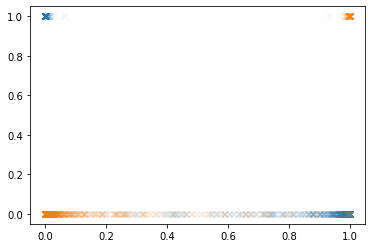

In [253]:
plt.plot(FN_output,trainlbl,'x',alpha=0.1)

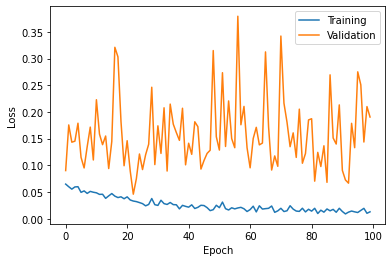

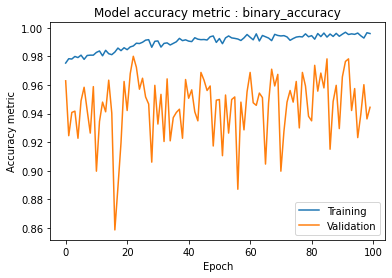

In [257]:
# model loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.title('Model loss : ' + loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

# model accuracy metric

plt.plot(np.array(history.history['binary_accuracy']))
plt.plot(np.array(history.history['val_' + 'binary_accuracy']))
plt.title('Model accuracy metric : ' + 'binary_accuracy')
plt.ylabel('Accuracy metric')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

## 2: FaceNET

In [275]:
train = np.load('drive/My Drive/Colab Notebooks/DLOI/week10/20faces-cropeed-train-128x128.npy')
trainlbl = np.load('drive/My Drive/Colab Notebooks/DLOI/week10/20faces-cropeed-trainlbl-128x128.npy')
test = np.load('drive/My Drive/Colab Notebooks/DLOI/week10/20faces-cropeed-test-128x128.npy')
testlbl = np.load('drive/My Drive/Colab Notebooks/DLOI/week10/20faces-cropeed-testlbl-128x128.npy')

In [276]:
train=rgb2gray(train)
test=rgb2gray(test)


In [277]:
train= train.reshape(train.shape[0], 128, 128, 1)  # add an extra dimension to array
test= test.reshape(test.shape[0], 128, 128, 1)  # add an extra dimension to array
output_train_class_onehot = tf.keras.utils.to_categorical(trainlbl, 20)  # create one-hot encoded class
output_test_class_onehot = tf.keras.utils.to_categorical(testlbl, 20)

In [278]:
model = tf.keras.Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(128,128,1)),
    MaxPooling2D(pool_size=4),
    Dropout(0.3),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=4),
    Dropout(0.3),
    Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=4),
    Dropout(0.3),
    #Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'),
    #MaxPooling2D(pool_size=2),
    #Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'), # No activation on final dense layer
    Dense(128, activation=None), # No activation on final dense layer
    Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

In [279]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_79 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 8, 8, 128)       

In [285]:
print(np.shape(trainlbl))
print(np.shape(train))

(5535,)
(5535, 128, 128, 1)


In [298]:
validtrain_split_ratio = 0.2  # % of the seen dataset to be put aside for validation, rest is for training
max_epochs = 80  # maxmimum number of epochs to be iterated
batch_size = 32   # batch size for the training data set
batch_shuffle = True   # shuffle the training data prior to batching before each epoch

In [299]:
# Compile the model
model.compile(
    optimizer=Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

In [300]:

# Train the network
history = model.fit(train,trainlbl, \
    batch_size=batch_size, \
    epochs=max_epochs, \
    validation_split=validtrain_split_ratio, \
    shuffle=batch_shuffle)

Epoch 1/80
139/139 [==============================] - 4s 26ms/step - loss: 0.8344 - val_loss: 1.7598
Epoch 2/80
139/139 [==============================] - 3s 24ms/step - loss: 0.8282 - val_loss: 1.8593
Epoch 3/80
139/139 [==============================] - 3s 24ms/step - loss: 0.8223 - val_loss: 1.8991
Epoch 4/80
139/139 [==============================] - 3s 24ms/step - loss: 0.8078 - val_loss: 1.8212
Epoch 5/80
139/139 [==============================] - 3s 24ms/step - loss: 0.7953 - val_loss: 1.8906
Epoch 6/80
139/139 [==============================] - 3s 24ms/step - loss: 0.8016 - val_loss: 1.8834
Epoch 7/80
139/139 [==============================] - 3s 24ms/step - loss: 0.8012 - val_loss: 1.9129
Epoch 8/80
139/139 [==============================] - 3s 24ms/step - loss: 0.8095 - val_loss: 1.8093
Epoch 9/80
139/139 [==============================] - 3s 24ms/step - loss: 0.7802 - val_loss: 1.9379
Epoch 10/80
139/139 [==============================] - 3s 24ms/step - loss: 0.7523 - val_lo

In [301]:
# Evaluate the network
FN_output = model.predict(train)

In [302]:
input_shape = (128)
inputs = Input(shape=input_shape)
layer1 = Dense(64)(inputs)
layer1 = Activation('relu')(layer1)
layer1 = Dropout(0.3)(layer1)
layer2 = Dense(20)(layer1)
outputs = Activation('softmax')(layer2)

In [303]:
# Compile the model

model_classifier = Model(inputs=inputs, outputs=outputs)
model_classifier.compile(
    optimizer=Adam(0.001),
    loss='CategoricalCrossentropy')

In [294]:
model_classifier.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_72 (Dense)             (None, 64)                8256      
_________________________________________________________________
activation_14 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_82 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 20)                1300      
_________________________________________________________________
activation_15 (Activation)   (None, 20)                0         
Total params: 9,556
Trainable params: 9,556
Non-trainable params: 0
_________________________________________________________

In [295]:

# Train the network
history = model_classifier.fit(FN_output,output_train_class_onehot, \
    batch_size=batch_size, \
    epochs=max_epochs, \
    validation_split=validtrain_split_ratio, \
    shuffle=batch_shuffle)

Epoch 1/20
139/139 [==============================] - 1s 5ms/step - loss: 2.6658 - val_loss: 5.2990
Epoch 2/20
139/139 [==============================] - 0s 4ms/step - loss: 1.7294 - val_loss: 6.9899
Epoch 3/20
139/139 [==============================] - 1s 4ms/step - loss: 1.6179 - val_loss: 7.8179
Epoch 4/20
139/139 [==============================] - 1s 4ms/step - loss: 1.5594 - val_loss: 8.2636
Epoch 5/20
139/139 [==============================] - 0s 4ms/step - loss: 1.5379 - val_loss: 8.5310
Epoch 6/20
139/139 [==============================] - 1s 4ms/step - loss: 1.5323 - val_loss: 8.7352
Epoch 7/20
139/139 [==============================] - 0s 4ms/step - loss: 1.4758 - val_loss: 8.9046
Epoch 8/20
139/139 [==============================] - 1s 4ms/step - loss: 1.4837 - val_loss: 9.0700
Epoch 9/20
139/139 [==============================] - 0s 3ms/step - loss: 1.4815 - val_loss: 9.3100
Epoch 10/20
139/139 [==============================] - 1s 4ms/step - loss: 1.4511 - val_loss: 9.4529

In [296]:
item = 32
FN_O = model.predict(test)

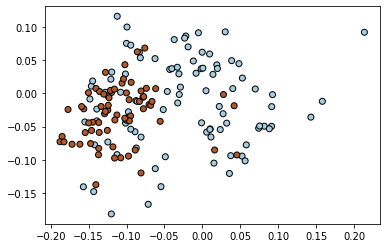

In [297]:
item1 = np.append(np.where(testlbl==1),np.where(testlbl==5))
labels = testlbl[item1]
FN_O1 = model.predict(test[item1])
input1 = 0
input2 = 1
plt.scatter(FN_O1[:, input1], FN_O1[:, input2], c=labels, cmap=plt.cm.Paired, edgecolors='k')
